```{index} single: application; transportation
```
```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} network optimization
```
```{index} single: AMPL; display
```

# Gasoline distribution

This notebook presents a transportation model to optimally allocate the delivery of a commodity from multiple sources to multiple destinations. The model invites a discussion of the pitfalls in optimizing a global objective for customers who may have an uneven share of the resulting benefits, then through model refinement arrives at a group cost-sharing plan to delivery costs.

Didactically, notebook presents techniques for AMPL modeling and reporting including:

* Accessing the duals (i.e., shadow prices)
* Methods for reporting the solution and duals.
    * `.display()` method for AMPL entities
    * Manually formatted reports
    * Pandas   

In [1]:
# install dependencies and select solver
%pip install -q amplpy

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.7 MB/s eta 0:00:00
Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [2]:
import pandas as pd
from IPython.display import HTML, display
import matplotlib.pyplot as plt

## Problem: Distributing gasoline to franchise operators

YaYa Gas-n-Grub is franchiser and operator for a network of regional convenience stores selling gasoline and convenience items in the United States. Each store is individually owned by a YaYa Gas-n-Grub franchisee who pays a fee to the franchiser for services.
Gasoline is delivered by truck from regional distribution terminals. Each delivery truck carries 8,000 gallons delivered at a fixed charge of 700€ per delivery, or 0.0875€  per gallon. The franchise owners are eager to reduce delivery costs to boost profits.
YaYa Gas-n-Grub decides to accept proposals from other distribution terminals, "A" and "B", to supply the franchise operators. Rather than a fixed fee per delivery, they proposed pricing based on location. But they already have existing customers, "A" and "B" can only provide a limited amount of gasoline to new customers totaling 100,000 and 80,000 gallons respectively. The only difference between the new suppliers and the current supplier is the delivery charge.

The following chart shows the pricing of gasoline delivery in cents/gallon.

| Franchisee <br> &nbsp; | Demand <br> &nbsp; |  Terminal A <br> 100,000| Terminal B <br> 80,000 | Current Supplier <br> 500,000 |
| :-------- | ------------: | :---------: | :-------: | :--------: |
| Alice | 30,000 | 8.3 | 10.2 | 8.75 |
| Badri  | 40,000 | 8.1 | 12.0 | 8.75 |
| Cara  | 50,000 | 8.3 | - | 8.75 |
| Dan   | 80,000 | 9.3 | 8.0 |  8.75 |
| Emma  | 30,000 | 10.1 | 10.0 | 8.75 |
| Fujita | 45,000 | 9.8 | 10.0 | 8.75 |
| Grace | 80,000 | -  | 8.0 | 8.75 |
| Helen | 18,000 | 7.5 | 10.0 | 8.75 |
| **TOTAL**| **313,000**| |  | | |

The operator of YaYa Gas-n-Grub has the challenge of allocating the gasoline delivery to minimize the cost to the franchise owners. The following model will present a global objective to minimize the total cost of delivery to all franchise owners.

## Model 1: Minimize total delivery cost

The decision variables for this example are labeled $x_{d, s}$ where subscript $d \in 1, \dots, n_d$ refers to the destination of the delivery and subscript $s \in 1, \dots, n_s$ to the source. The value of $x_{d,s}$ is the volume of gasoline shipped to destination $d$ from source $s$.
Given the cost rate $r_{d, s}$ for shipping one unit of goods from $d$ to $s$, the objective is to minimize the total cost of transporting gasoline from the sources to the destinations subject to meeting the demand requirements, $D_d$, at all destinations, and satisfying the supply constraints, $S_s$, at all sources. The full mathematical formulation is:

$$
\begin{align*}
    \min \quad & \sum_{d=1}^{n_d} \sum_{s=1}^{n_s} r_{d, s} x_{d, s} \\
    \text{s.t.} \quad &\sum_{s=1}^{n_s} x_{d, s}  = D_d & \forall \, d\in 1, \dots, n_d & \quad \text{(demand constraints)}\\
    & \sum_{d=1}^{n_d} x_{d, s}  \leq S_s & \forall \, s\in 1, \dots, n_s & \quad \text{(supply constraints)}
\end{align*}
$$


## Data Entry

The data is stored into Pandas DataFrame and Series objects. Note the use of a large rates to avoid assigning shipments to destination-source pairs not allowed by the problem statement.

In [3]:
rates = pd.DataFrame(
    [
        ["Alice", 8.3, 10.2, 8.75],
        ["Badri", 8.1, 12.0, 8.75],
        ["Cara", 8.3, 100.0, 8.75],
        ["Dan", 9.3, 8.0, 8.75],
        ["Emma", 10.1, 10.0, 8.75],
        ["Fujita", 9.8, 10.0, 8.75],
        ["Grace", 100, 8.0, 8.75],
        ["Helen", 7.5, 10.0, 8.75],
    ],
    columns=["Destination", "Terminal A", "Terminal B", "Current Supplier"],
).set_index("Destination")

demand = pd.Series(
    {
        "Alice": 30000,
        "Badri": 40000,
        "Cara": 50000,
        "Dan": 20000,
        "Emma": 30000,
        "Fujita": 45000,
        "Grace": 80000,
        "Helen": 18000,
    },
    name="demand",
)

supply = pd.Series(
    {"Terminal A": 100000, "Terminal B": 80000, "Current Supplier": 500000},
    name="supply",
)

display(HTML("<br><b>Gasoline Supply (Gallons)</b>"))
display(supply.to_frame())

display(HTML("<br><b>Gasoline Demand (Gallons)</b>"))
display(demand.to_frame())

display(HTML("<br><b>Transportation Rates (€ cents per Gallon)</b>"))
display(rates)

,supply
Terminal A,100000
Terminal B,80000
Current Supplier,500000


,demand
Alice,30000
Badri,40000
Cara,50000
Dan,20000
Emma,30000
Fujita,45000
Grace,80000
Helen,18000


,Terminal A,Terminal B,Current Supplier
Destination,,,
Alice,8.3,10.2,8.75
Badri,8.1,12.0,8.75
Cara,8.3,100.0,8.75
Dan,9.3,8.0,8.75
Emma,10.1,10.0,8.75
Fujita,9.8,10.0,8.75
Grace,100.0,8.0,8.75
Helen,7.5,10.0,8.75


The following AMPL model is an implementation of the mathematical optimization model described above. The sets and indices have been designated with more descriptive symbols readability and maintenance.

In [4]:
%%writefile transport.mod

set SOURCES;
set DESTINATIONS;

param Rates{DESTINATIONS, SOURCES};
param supply{SOURCES};
param demand{DESTINATIONS};

var x{DESTINATIONS, SOURCES} >= 0;

minimize total_cost:
    sum{dst in DESTINATIONS, src in SOURCES} Rates[dst, src] * x[dst, src];

var cost_to_destination {dst in DESTINATIONS} =
    sum{src in SOURCES} Rates[dst, src] * x[dst, src];

var shipped_to_destination {dst in DESTINATIONS} =
    sum{src in SOURCES} x[dst, src];

var shipped_from_source {src in SOURCES} =
    sum{dst in DESTINATIONS} x[dst, src];

s.t. supply_constraint {src in SOURCES}:
    shipped_from_source[src] <= supply[src];

s.t. demand_constraint {dst in DESTINATIONS}:
    shipped_to_destination[dst] == demand[dst];

Writing transport.mod


HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 26113.5
1 simplex iterations
0 barrier iterations
 
Old Delivery Costs = 27387.50€
New Delivery Costs = 26113.50€



,Terminal A,Terminal B,Current Supplier,current costs,contract costs,savings,contract rate,marginal cost
Destination,,,,,,,,
Alice,0,0,30000,2625.0,2625.0,0.0,0.0875,0.0875
Badri,40000,0,0,3500.0,3240.0,260.0,0.0810,0.0855
Cara,42000,0,8000,4375.0,4186.0,189.0,0.0837,0.0875
Dan,0,0,20000,1750.0,1750.0,0.0,0.0875,0.0875
Emma,0,0,30000,2625.0,2625.0,0.0,0.0875,0.0875
Fujita,0,0,45000,3937.5,3937.5,0.0,0.0875,0.0875
Grace,0,80000,0,7000.0,6400.0,600.0,0.0800,0.0875
Helen,18000,0,0,1575.0,1350.0,225.0,0.0750,0.0795


<Axes: xlabel='Destination'>

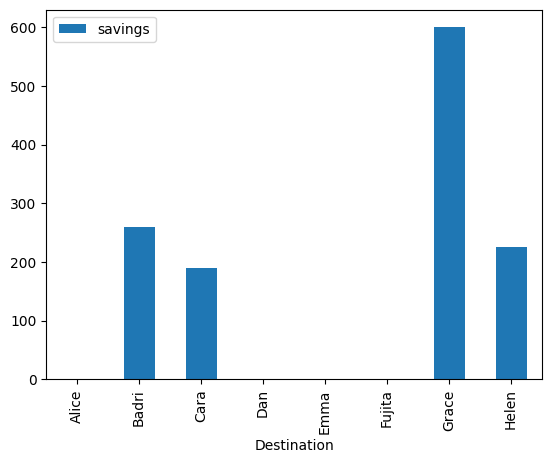

In [5]:
def transport(supply, demand, rates):
    m = AMPL()
    m.read("transport.mod")

    m.set["SOURCES"] = rates.columns
    m.set["DESTINATIONS"] = rates.index

    m.param["Rates"] = rates
    m.param["supply"] = supply
    m.param["demand"] = demand

    m.option["solver"] = SOLVER
    m.solve()

    return m


def get_results(m):
    results = m.var["x"].to_pandas().unstack()
    results.columns = results.columns.get_level_values(1)
    results = results.reindex(index=rates.index, columns=rates.columns)
    results["current costs"] = 700 * demand / 8000
    results["contract costs"] = m.var["cost_to_destination"].to_pandas()
    results["savings"] = results["current costs"].round(1) - results[
        "contract costs"
    ].round(1)
    results["contract rate"] = round(results["contract costs"] / demand, 4)
    results["marginal cost"] = m.con["demand_constraint"].to_pandas()

    return results


m = transport(supply, demand, rates / 100)

model1_results = get_results(m)

print(f"Old Delivery Costs = {sum(demand)*700/8000:.2f}€")
print(f"New Delivery Costs = {m.obj['total_cost'].value():.2f}€\n")
display(model1_results)

model1_results.plot(y="savings", kind="bar")

## Model 2: Minimize cost rate for franchise owners

Minimizing total costs provides no guarantee that individual franchise owners will benefit equally, or in fact benefit at all, from minimizing total costs. In this example neither Emma or Fujita would save any money on delivery costs, and the majority of savings goes to just two of the franchisees.  Without a better distribution of the benefits there may be little enthusiasm among the franchisees to adopt change. This observation motivates an attempt at a second model. In this case the objective is minimize a common rate for the cost of gasoline distribution subject to meeting the demand and supply constraints, $S_s$, at all sources. The mathematical formulation of this different problem is as follows:

$$
\begin{align*}
    \min \quad & \rho \\
    \text{s.t.} \quad &\sum_{s=1}^{n_s} x_{d, s}  = D_d & \forall \, d\in 1, \dots, n_d & \quad \text{(demand constraints)}\\
    & \sum_{d=1}^{n_d} x_{d, s}  \leq S_s & \forall \, s\in 1, \dots, n_s & \quad \text{(supply constraints)}\\
    & \sum_{s=1}^{n_s} r_{d, s} x_{d, s} \leq \rho D_d & \forall d\in 1, \dots, n_d & \quad \text{(common cost rate)}\\
\end{align*}
$$

The following AMPL model implements this formulation.

In [6]:
%%writefile transport2.mod

set SOURCES;
set DESTINATIONS;

param Rates{DESTINATIONS, SOURCES};
param supply{SOURCES};
param demand{DESTINATIONS};

var x{DESTINATIONS, SOURCES} >= 0;
var rate;

minimize delivery_rate: rate;

var cost_to_destination {dst in DESTINATIONS} =
    sum{src in SOURCES} Rates[dst, src] * x[dst, src];

var total_cost = sum{dst in DESTINATIONS} cost_to_destination[dst];

s.t. rate_to_destination {dst in DESTINATIONS}:
    cost_to_destination[dst] == rate * demand[dst];

var shipped_to_destination {dst in DESTINATIONS} =
    sum{src in SOURCES} x[dst, src];

var shipped_from_source {src in SOURCES} =
    sum{dst in DESTINATIONS} x[dst, src];

s.t. supply_constraint {src in SOURCES}:
    shipped_from_source[src] <= supply[src];

s.t. demand_constraint {dst in DESTINATIONS}:
    shipped_to_destination[dst] == demand[dst];

Writing transport2.mod


HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 0.0875
12 simplex iterations
0 barrier iterations
 
Old Delivery Costs = $ 27387.5
New Delivery Costs = $ 27387.5


,Terminal A,Terminal B,Current Supplier,current costs,contract costs,savings,contract rate,marginal cost
Destination,,,,,,,,
Alice,22894.7,7105.3,0.0,2625.0,2625.0,0.0,0.1,0.0
Badri,0.0,0.0,40000.0,3500.0,3500.0,0.0,0.1,0.0
Cara,49754.6,245.4,0.0,4375.0,4375.0,0.0,0.1,0.0
Dan,0.0,0.0,20000.0,1750.0,1750.0,0.0,0.1,0.0
Emma,0.0,0.0,30000.0,2625.0,2625.0,0.0,0.1,0.0
Fujita,0.0,0.0,45000.0,3937.5,3937.5,0.0,0.1,0.0
Grace,0.0,0.0,80000.0,7000.0,7000.0,0.0,0.1,0.0
Helen,9000.0,9000.0,0.0,1575.0,1575.0,0.0,0.1,0.0


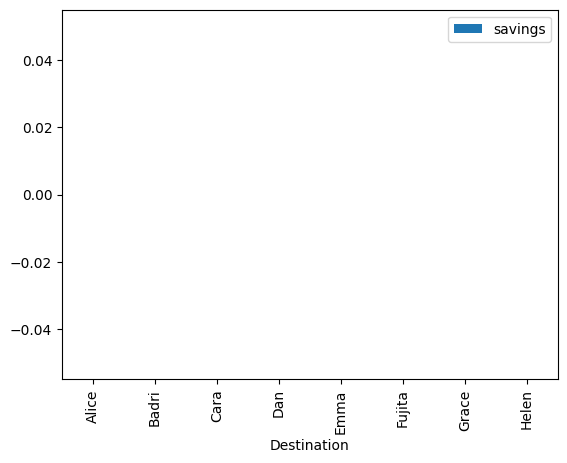

In [7]:
def transport2(supply, demand, rates):
    m = AMPL()
    m.read("transport2.mod")

    m.set["SOURCES"] = rates.columns
    m.set["DESTINATIONS"] = rates.index

    m.param["Rates"] = rates
    m.param["supply"] = supply
    m.param["demand"] = demand

    m.option["solver"] = SOLVER
    m.solve()

    return m


m = transport2(supply, demand, rates / 100)

print(f"Old Delivery Costs = $ {sum(demand)*700/8000}")
print(f"New Delivery Costs = $ {m.var['total_cost'].value()}")
results = get_results(m)
display(results.round(1))

results.plot(y="savings", kind="bar")
plt.show()

## Model 3: Minimize total cost for a cost-sharing plan

The prior two models demonstrated some practical difficulties in realizing the benefits of a cost optimization plan. Model 1 will likely fail in a franchiser/franchisee arrangement because the realized savings would be fore the benefit of a few.

Model 2 was an attempt to remedy the problem by solving for an allocation of deliveries that would lower the cost rate that would be paid by each franchisee directly to the gasoline distributors. Perhaps surprisingly, the resulting solution offered no savings to any franchisee. Inspecting the data shows the source of the problem is that two franchisees, Emma and Fujita, simply have no lower cost alternative than the current supplier. Therefore finding a distribution plan with direct payments to the distributors that lowers everyone's cost is an impossible task.

The third model addresses this problem with a plan to share the cost savings among the franchisees. In this plan, the franchiser would collect delivery fees from the franchisees to pay the gasoline distributors. The optimization objective returns to the problem to minimizing total delivery costs, but then adds a constraint that defines a common cost rate to charge all franchisees. By offering a benefit to all parties, the franchiser offers incentive for group participation in contracting for gasoline distribution services.

In mathematical terms, the problem can be formulated as follows:

$$
\begin{align*}
    \min \quad & \sum_{d=1}^{n_d} \sum_{s=1}^{n_s} r_{d, s} x_{d, s} \\
    \text{s.t.} \quad &\sum_{s=1}^{n_s} x_{d, s}  = D_d & \forall \, d\in 1, \dots, n_d & \quad \text{(demand constraints)}\\
    & \sum_{d=1}^{n_d} x_{d, s}  \leq S_s & \forall \, s\in 1, \dots, n_s & \quad \text{(supply constraints)}\\
    & \sum_{s=1}^{n_s} r_{d, s} x_{d, s} = \rho D_d & \forall d\in 1, \dots, n_d & \quad \text{(uniform cost sharing rate)}\\
\end{align*}
$$

In [8]:
%%writefile transport3.mod

set SOURCES;
set DESTINATIONS;

param Rates{DESTINATIONS, SOURCES};
param supply{SOURCES};
param demand{DESTINATIONS};

var x{DESTINATIONS, SOURCES} >= 0;
var rate;

minimize total_cost:
    sum{dst in DESTINATIONS, src in SOURCES} Rates[dst, src] * x[dst, src];

var cost_to_destination {dst in DESTINATIONS} =
    rate * demand[dst];

s.t. allocate_costs:
    sum{dst in DESTINATIONS} cost_to_destination[dst] == m.total_cost;

var shipped_to_destination {dst in DESTINATIONS} =
    sum{src in SOURCES} x[dst, src];

var shipped_from_source {src in SOURCES} =
    sum{dst in DESTINATIONS} x[dst, src];

s.t. supply_constraint {src in SOURCES}:
    shipped_from_source[src] <= supply[src];

s.t. demand_constraint {dst in DESTINATIONS}:
    shipped_to_destination[dst] == demand[dst];

Writing transport3.mod


HiGHS 1.5.3: HiGHS 1.5.3: optimal solution; objective 26113.5
1 simplex iterations
0 barrier iterations
 
Old Delivery Costs = 27387.50€
New Delivery Costs = 26113.50€



,Terminal A,Terminal B,Current Supplier,current costs,contract costs,savings,contract rate,marginal cost
Destination,,,,,,,,
Alice,0,0,30000,2625.0,2625.0,0.0,0.0875,0.0875
Badri,40000,0,0,3500.0,3240.0,260.0,0.0810,0.0855
Cara,42000,0,8000,4375.0,4186.0,189.0,0.0837,0.0875
Dan,0,0,20000,1750.0,1750.0,0.0,0.0875,0.0875
Emma,0,0,30000,2625.0,2625.0,0.0,0.0875,0.0875
Fujita,0,0,45000,3937.5,3937.5,0.0,0.0875,0.0875
Grace,0,80000,0,7000.0,6400.0,600.0,0.0800,0.0875
Helen,18000,0,0,1575.0,1350.0,225.0,0.0750,0.0795


<Axes: xlabel='Destination'>

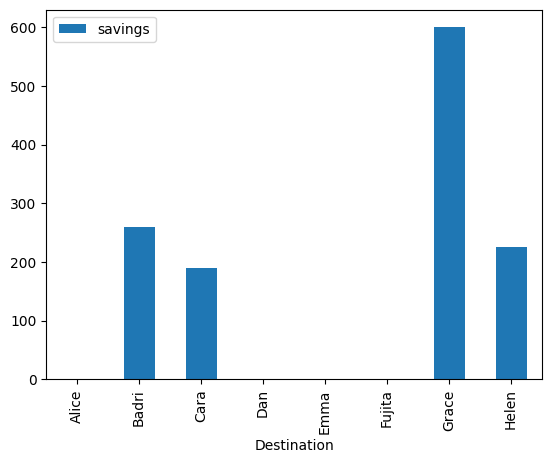

In [9]:
def transport3(supply, demand, rates):
    m = AMPL()
    m.read("transport3.mod")

    m.set["SOURCES"] = rates.columns
    m.set["DESTINATIONS"] = rates.index

    m.param["Rates"] = rates
    m.param["supply"] = supply
    m.param["demand"] = demand

    m.option["solver"] = SOLVER
    m.solve()

    return m


m = transport(supply, demand, rates / 100)

print(f"Old Delivery Costs = {sum(demand)*700/8000:.2f}€")
print(f"New Delivery Costs = {m.obj['total_cost'].value():.2f}€\n")
model3_results = get_results(m)
display(model3_results)

model3_results.plot(y="savings", kind="bar")

## Comparing model results

The following charts demonstrate the difference in outcomes for Model 1 and Model 3 (Model 2 was left out as entirely inadequate). The group cost-sharing arrangement produces the same group savings, but distributes the benefits in a manner likely to be more acceptable to the majority of participants.

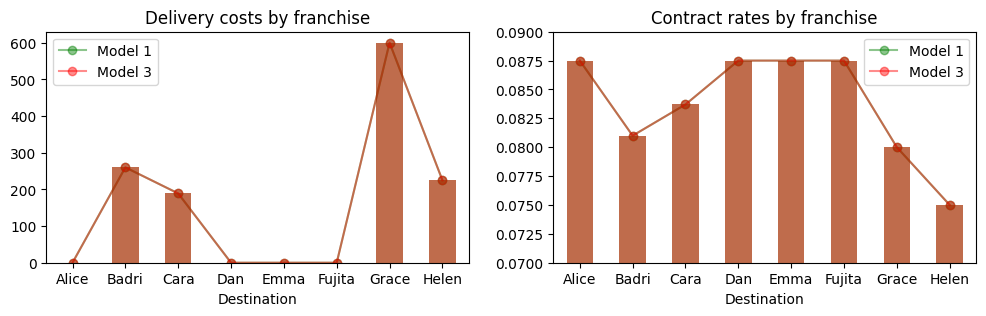

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
alpha = 0.45

model1_results.plot(y=["savings"], kind="bar", ax=ax[0], color="g", alpha=alpha)
model1_results.plot(y="savings", marker="o", ax=ax[0], color="g", alpha=alpha)

model3_results.plot(y="savings", kind="bar", ax=ax[0], color="r", alpha=alpha)
model3_results.plot(y="savings", marker="o", ax=ax[0], color="r", alpha=alpha)
ax[0].legend(["Model 1", "Model 3"])
ax[0].set_title("Delivery costs by franchise")

model1_results.plot(y=["contract rate"], kind="bar", ax=ax[1], color="g", alpha=alpha)
model1_results.plot(y="contract rate", marker="o", ax=ax[1], color="g", alpha=alpha)

model3_results.plot(y="contract rate", kind="bar", ax=ax[1], color="r", alpha=alpha)
model3_results.plot(y="contract rate", marker="o", ax=ax[1], color="r", alpha=alpha)
ax[1].set_ylim(0.07, 0.09)
ax[1].legend(["Model 1", "Model 3"])
ax[1].set_title("Contract rates by franchise")
plt.show()

## Didactics: Reporting solutions

AMPL models can produce considerable amounts of data that must be summarized and presented for analysis and decision making. In this application, for example, the individual franchise owners receive differing amounts of savings which is certain to result in considerable discussion and possibly negotiation with the franchiser.

The following cells demonstrate techniques for extracting and displaying information generated by an AMPL model.

### AMPL `.display()` method

AMPL provides a default `.display()` method for AMPL entities. The default display is often sufficient for model reporting requirements, particularly when initially developing a new application.

In [11]:
# display elements of sets
m.display("SOURCES")
m.display("DESTINATIONS")

set SOURCES := 'Terminal A' 'Terminal B' 'Current Supplier';

set DESTINATIONS := Alice Badri Cara Dan Emma Fujita Grace Helen;



In [12]:
# display elements of an indexed parameter
m.display("Rates")

Rates [*,*]
:      'Current Supplier' 'Terminal A' 'Terminal B'    :=
Alice         0.0875          0.083        0.102
Badri         0.0875          0.081        0.12
Cara          0.0875          0.083        1
Dan           0.0875          0.093        0.08
Emma          0.0875          0.101        0.1
Fujita        0.0875          0.098        0.1
Grace         0.0875          1            0.08
Helen         0.0875          0.075        0.1
;



In [13]:
# display elements of an auxiliary variable
m.display("shipped_to_destination")

shipped_to_destination [*] :=
 Alice  30000
 Badri  40000
  Cara  50000
   Dan  20000
  Emma  30000
Fujita  45000
 Grace  80000
 Helen  18000
;



In [14]:
m.display("shipped_from_source")

shipped_from_source [*] :=
'Current Supplier'  133000
      'Terminal A'   1e+05
      'Terminal B'   80000
;



In [15]:
# display Objective
m.display("total_cost")

total_cost = 26113.5



In [16]:
# display indexed Constraints
m.display("supply_constraint")  # dual is displayed by default
m.display(
    "supply_constraint.lb, supply_constraint.body, supply_constraint.ub, supply_constraint.dual"
)
m.display("demand_constraint")

supply_constraint [*] :=
'Current Supplier'   0
      'Terminal A'  -0.0045
      'Terminal B'  -0.0075
;

# $2 = supply_constraint.body
# $3 = supply_constraint.ub
# $4 = supply_constraint.dual
:                  supply_constraint.lb     $2      $3       $4       :=
'Current Supplier'       -Infinity        133000   5e+05    0
'Terminal A'             -Infinity         1e+05   1e+05   -0.0045
'Terminal B'             -Infinity         80000   80000   -0.0075
;

demand_constraint [*] :=
 Alice  0.0875
 Badri  0.0855
  Cara  0.0875
   Dan  0.0875
  Emma  0.0875
Fujita  0.0875
 Grace  0.0875
 Helen  0.0795
;



In [17]:
# display decision variables
m.display("x")

x [*,*]
:      'Current Supplier' 'Terminal A' 'Terminal B'    :=
Alice         30000               0            0
Badri             0           40000            0
Cara           8000           42000            0
Dan           20000               0            0
Emma          30000               0            0
Fujita        45000               0            0
Grace             0               0        80000
Helen             0           18000            0
;



In [18]:
# display decision variables with bounds and reduced cost
m.display("x.lb", "x", "x.ub", "x.rc")

:                         x.lb     x       x.ub     x.rc     :=
Alice  'Current Supplier'   0    30000   Infinity   0
Alice  'Terminal A'         0        0   Infinity   0
Alice  'Terminal B'         0        0   Infinity   0.022
Badri  'Current Supplier'   0        0   Infinity   0.002
Badri  'Terminal A'         0    40000   Infinity   0
Badri  'Terminal B'         0        0   Infinity   0.042
Cara   'Current Supplier'   0     8000   Infinity   0
Cara   'Terminal A'         0    42000   Infinity   0
Cara   'Terminal B'         0        0   Infinity   0.92
Dan    'Current Supplier'   0    20000   Infinity   0
Dan    'Terminal A'         0        0   Infinity   0.01
Dan    'Terminal B'         0        0   Infinity   0
Emma   'Current Supplier'   0    30000   Infinity   0
Emma   'Terminal A'         0        0   Infinity   0.018
Emma   'Terminal B'         0        0   Infinity   0.02
Fujita 'Current Supplier'   0    45000   Infinity   0
Fujita 'Terminal A'         0        0   Infini

### Manually formatted reports

Following solution, the value associated with AMPL entities are returned by calling the entity as a function. The following cell demonstrates the construction of a custom report using Python f-strings and AMPL methods.

In [19]:
# Objective report
print("\nObjective: cost")
print(f"cost = {m.obj['total_cost'].value()}")

SOURCES = m.set["SOURCES"].to_list()
DESTINATIONS = m.set["DESTINATIONS"].to_list()

# Constraint reports
supply_constraint_body = m.get_data("supply_constraint.body").to_dict()
supply_constraint_rc = m.con["supply_constraint"].to_dict()
print("\nConstraint: supply_constraint")
for src in SOURCES:
    print(
        f"{src:12s}  {supply_constraint_body[src]:8.2f}  {supply_constraint_rc[src]:8.2f}"
    )

demand_constraint_body = m.get_data("demand_constraint.body").to_dict()
demand_constraint_rc = m.con["demand_constraint"].to_dict()
print("\nConstraint: demand_constraint")
for dst in DESTINATIONS:
    print(
        f"{dst:12s}  {demand_constraint_body[dst]:8.2f}  {demand_constraint_rc[dst]:8.2f}"
    )

# Decision variable reports
print("\nDecision variables: x")
x = m.var["x"].to_dict()
for src in SOURCES:
    for dst in DESTINATIONS:
        print(f"{src:12s} -> {dst:12s}  {x[dst, src]:8.2f}")
    print()


Objective: cost
cost = 26113.5

Constraint: supply_constraint
Terminal A    100000.00     -0.00
Terminal B    80000.00     -0.01
Current Supplier  133000.00      0.00

Constraint: demand_constraint
Alice         30000.00      0.09
Badri         40000.00      0.09
Cara          50000.00      0.09
Dan           20000.00      0.09
Emma          30000.00      0.09
Fujita        45000.00      0.09
Grace         80000.00      0.09
Helen         18000.00      0.08

Decision variables: x
Terminal A   -> Alice             0.00
Terminal A   -> Badri         40000.00
Terminal A   -> Cara          42000.00
Terminal A   -> Dan               0.00
Terminal A   -> Emma              0.00
Terminal A   -> Fujita            0.00
Terminal A   -> Grace             0.00
Terminal A   -> Helen         18000.00

Terminal B   -> Alice             0.00
Terminal B   -> Badri             0.00
Terminal B   -> Cara              0.00
Terminal B   -> Dan               0.00
Terminal B   -> Emma              0.00
Termin

### Pandas

The Python Pandas library provides a highly flexible framework for data science applications. The next cell demonstrates the translation of values of AMPL entities to Pandas DataFrames

,supply,shipped,sensitivity
Terminal A,100000,100000,-0.0045
Terminal B,80000,80000,-0.0075
Current Supplier,500000,133000,0.0000


,demand,shipped,sensitivity
Alice,30000,30000,0.0875
Badri,40000,40000,0.0855
Cara,50000,50000,0.0875
Dan,20000,20000,0.0875
Emma,30000,30000,0.0875
Fujita,45000,45000,0.0875
Grace,80000,80000,0.0875
Helen,18000,18000,0.0795


sources,Current Supplier,Terminal A,Terminal B
destinations,,,
Alice,30000,0,0
Badri,0,40000,0
Cara,8000,42000,0
Dan,20000,0,0
Emma,30000,0,0
Fujita,45000,0,0
Grace,0,0,80000
Helen,0,18000,0


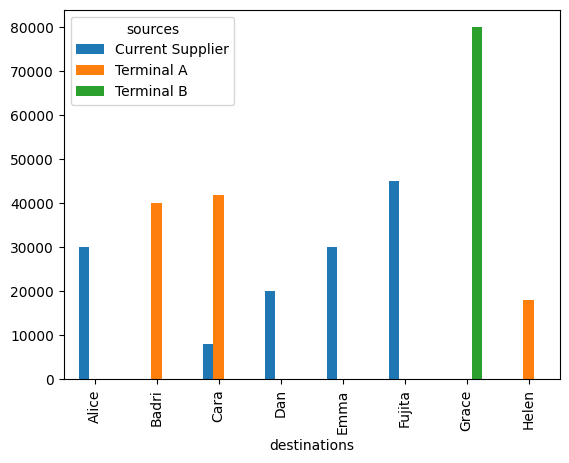

In [20]:
suppliers = pd.DataFrame(supply)
suppliers["shipped"] = m.get_data("supply_constraint.body").to_pandas()
suppliers["sensitivity"] = m.con["supply_constraint"].to_pandas()

display(suppliers)

customers = pd.DataFrame(demand)
customers["shipped"] = m.get_data("demand_constraint.body").to_pandas()
customers["sensitivity"] = m.con["demand_constraint"].to_pandas()

display(customers)

shipments = m.var["x"].to_pandas()
shipments.index.names = ["destinations", "sources"]
shipments = shipments.unstack()
shipments.columns = shipments.columns.get_level_values(1)
display(shipments)
shipments.plot(kind="bar")
plt.show()

### Graphviz

The `graphviz` utility is a collection of tools for visually graphs and directed graphs. Unfortunately, the package can be troublesome to install on laptops in a way that is compatible with many JupyterLab installations. Accordingly, the following cell is intended for use on Google Colab which provides a preinstalled version of `graphviz`.

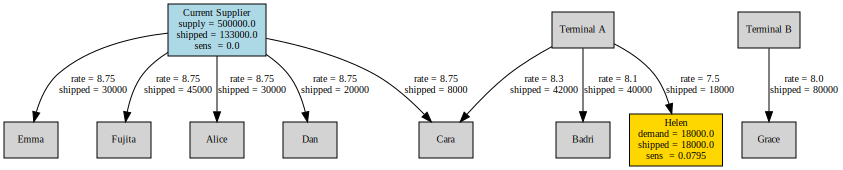

In [26]:
import sys


if "google.colab" in sys.modules:
    import graphviz
    from graphviz import Digraph

    dot = Digraph(
        node_attr={"fontsize": "10", "shape": "rectangle", "style": "filled"},
        edge_attr={"fontsize": "10"},
    )

    for index, row in suppliers.iterrows():
        label = (
            f"{index}"
            + f"\nsupply = {row['supply']}"
            + f"\nshipped = {row['shipped']}"
            + f"\nsens  = {row['sensitivity']}"
        )
        dot.node(src, label=label, fillcolor="lightblue")

    for index, row in customers.iterrows():
        label = (
            f"{dst}"
            + f"\ndemand = {row['demand']}"
            + f"\nshipped = {row['shipped']}"
            + f"\nsens  = {row['sensitivity']:.6g}"
        )
        dot.node(dst, label=label, fillcolor="gold")

    for src in SOURCES:
        for dst in DESTINATIONS:
            if shipments.loc[dst, src] > 0:
                dot.edge(
                    src,
                    dst,
                    f"rate = {rates.loc[dst, src]}\nshipped = {shipments.loc[dst, src]}",
                )

    display(dot)